## **라이브러리 다운로드 및 불러오기**

In [ ]:
## 라이브러리 다운로드

# 한글깨짐 해결('코드 실행' → '런타임' → '세션 다시시작' 실행)
!pip install matplotlib -U
!sudo apt-get install -y fonts-nanum
!sudo fc-cache -fv
!rm ~/.cache/matplotlib -rf

# 워드클라우드
!pip install nltk
!pip install wordcloud
!pip install konlpy

In [1]:
## 라이브러리 불러오기

# 데이터 핸들링
import numpy as np
import pandas as pd
from tqdm import tqdm, trange
import re

# 데이터 시각화
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
import matplotlib
matplotlib.rcParams['axes.unicode_minus'] = False  # plot "-" 부호 표기 설정

pd.set_option('display.max_columns', None)
pd.options.display.float_format = '{:.4f}'.format

# 경고 안내 무시
import warnings
warnings.filterwarnings('ignore')

pd.set_option('display.max_row', 200)       # row 출력제한 해제
pd.set_option('display.max_columns', 100)   # column 출력제한 해제

In [2]:
#구글드라이브 연동
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [9]:
## 함수 정의

# 파이차트 시각화 정의
colors = ['#ff9999', '#ffc000', '#8fd9b6', '#d395d0', 'silver', 'lightgray', 'whitesmoke']
wedgeprops={'width': 0.7, 'edgecolor': 'w', 'linewidth': 5}

def make_pie(data01, data01_label, plot_name):
  plt.pie(data01, labels=data01_label, startangle=260, pctdistance=0.8, autopct='%.1f%%', colors=colors, counterclock=False, wedgeprops=wedgeprops)
  plt.title(plot_name, fontsize=11, fontweight ="bold")
  plot_option01()

# 시각화 옵션 정의(1)
def plot_option01():
    plt.rc('font', family='NanumBarunGothic')                      # 폰트
    plt.xticks(rotation=0, size = 9, fontweight ="bold")           # X축 크기 및 굵기
    plt.yticks(size = 9, fontweight ="bold")                       # y축 크기 및 굵기
    plt.grid(False)                                                # 차트 선 제거

# 시각화 옵션 정의(2)
def plot_option02(input_xlabel, input_ylabel, plot_name):
    plot_option01()                                                # 시각화 옵션 정의(1) 불러오기
    plt.xlabel(input_xlabel, fontweight='bold')                    # x축 이름
    plt.ylabel(input_ylabel, fontweight='bold')                    # y축 이름
    plt.title(plot_name, fontsize=11, fontweight ="bold")          # 차트 이름

---

### **데이터 불러오기**

In [4]:
# 데이터 불러오기
MDunpa_df06 = pd.read_csv('/content/drive/MyDrive/3. Research/[기업] 분석 과제/네오플 트렌드 분석/Data/Fianl_Review_Dataset_06.csv')

# 데이터 정제
del MDunpa_df06["Unnamed: 0"]
MDunpa_df06 = MDunpa_df06[MDunpa_df06["filtering"]!="불일치"]

# 데이터 타입 변환
MDunpa_df06 = MDunpa_df06.astype("str")
MDunpa_df06 = MDunpa_df06.astype({'평점': 'int', '감성점수': 'int', '유용성': 'int', '핵심평점(속01)': 'float','주변평점(속02)': 'float','감성평점(속03)': 'float'})
MDunpa_df06["작성일자"] = pd.to_datetime(MDunpa_df06["작성일자"])

# 데이터 순서 변경
MDunpa_df06 = MDunpa_df06[['리뷰_ID', '고객_ID', '평점', '평점극성', '핵심평점(속01)', '주변평점(속02)', '감성평점(속03)', '감성점수', '감성극성', '유용성', '(원본)리뷰어',
                           '(정제)리뷰어', '품사(빈도)', '품사(감성)', '작성일자', '년', '월', '일', 'Binary', 'filtering', '감정', 'cluster_03', 'cluster_04', 'cluster_05']]

# 데이터 변수명 변경
MDunpa_df06.columns = ['리뷰_ID', '고객_ID', '평점', '평점극성', '핵심평점(속성01)', '주변평점(속성02)', '감성평점(속성03)','감성점수', '감성극성', '유용성', '(원본)리뷰어',
                       '(정제)리뷰어', '품사(빈도)', '품사(감성)', '작성일자','년', '월', '일', '게임대상(전/후)', '불일치', '감정', '군집_03', '군집_04','군집_05']

print(MDunpa_df06.shape)

(10653, 24)


In [5]:
## 데이터 재정의

# KGA대상 이전(22.11.16 이전)
Before_Data = MDunpa_df06[MDunpa_df06["게임대상(전/후)"]=="Befor"]
Before_Data = Before_Data.reset_index(); del Before_Data["index"]
Before_Data["작성일자"] = pd.to_datetime(Before_Data["작성일자"])

# KGA대상 이후(22.11.16 이후)
After_Data = MDunpa_df06[MDunpa_df06["게임대상(전/후)"]=="After"]
After_Data = After_Data.reset_index(); del After_Data["index"]
After_Data["작성일자"] = pd.to_datetime(After_Data["작성일자"])

print(Before_Data.shape)
print(After_Data.shape)

(9883, 24)
(770, 24)


### **KGA대상 전/후 감정 비교**

In [6]:
## 데이터 재정의

# KGA대상 이전
Before_labels = list(Before_Data["감정"].value_counts().sort_index(ascending=False).index)
Before_emotion_count = list(Before_Data["감정"].value_counts().sort_index(ascending=False).values)
Before_ratio = []
for i in range(0, len(Before_labels)):
  sample_data01 = Before_emotion_count[i]; sample_data02 = (sample_data01/9883) * 100; Before_ratio.append(sample_data02)

# KGA대상 후
After_labels = list(After_Data["감정"].value_counts().sort_index(ascending=False).index)
After_emotion_count = list(After_Data["감정"].value_counts().sort_index(ascending=False).values)
After_ratio = []
for i in range(0, len(Before_labels)):
  sample_data01 = After_emotion_count[i]; sample_data02 = (sample_data01/770) * 100; After_ratio.append(sample_data02)

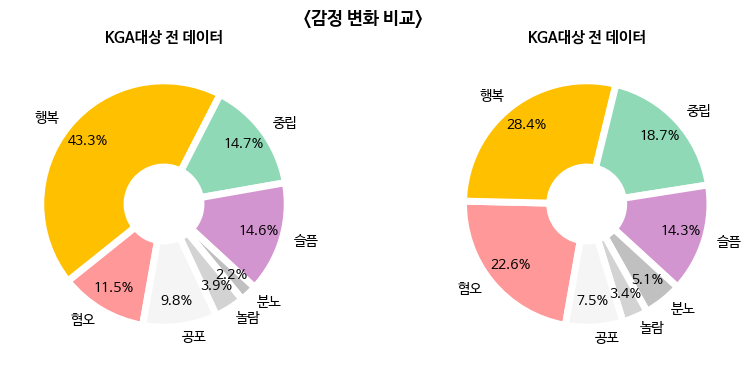

In [11]:
# 시각화

plt.rcParams["figure.figsize"] = (10, 4)
plt.suptitle('<감정 변화 비교>', fontsize=13, fontweight ="bold")

plt.subplot(1, 2, 1)
make_pie(Before_ratio, Before_labels, "KGA대상 전 데이터")

plt.subplot(1, 2, 2)
make_pie(After_ratio, After_labels, "KGA대상 전 데이터")
plt.show()

___

### **KGA대상 전/후 세부속성별 평점, 평균점수 비교**

In [12]:
## 데이터 재정의

# KGA대상 전 데이터의 세부속성별 평점평균
Before_Key_number    = Before_Data['핵심평점(속성01)'].mean()
Before_Around_number = Before_Data['주변평점(속성02)'].mean()
Before_senti_number  = Before_Data['감성평점(속성03)'].mean()
before_3aspect = [Before_Key_number, Before_Around_number, Before_senti_number]

# KGA대상 후 데이터의 세부속성별 평점평균
After_Key_number    = After_Data['핵심평점(속성01)'].mean()
After_Around_number = After_Data['주변평점(속성02)'].mean()
After_senti_number  = After_Data['감성평점(속성03)'].mean()
after_3aspect = [After_Key_number, After_Around_number, After_senti_number]

label = ["핵심", "주변", "감성"]
x = np.arange(len(label))

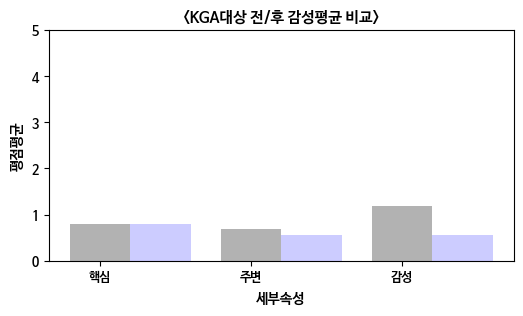

In [13]:
plt.rcParams["figure.figsize"] = (6,3)
plot_option02("세부속성", "평점평균", "<KGA대상 전/후 감성평균 비교>")
plt.xticks(x, label); plt.ylim([0, 5])

plt.bar(x-0.0, before_3aspect, color = 'k', alpha = 0.3, label = "대상 전", width=0.4, align='center')
plt.bar(x+0.4, after_3aspect, color = 'blue', alpha = 0.2, label = "대상 후", width=0.4, align='center')
plt.show()

### **KGA대상 전/후 감성극성, 데이터 수 비교**

In [14]:
## 데이터 재정의

# KGA대상 전 데이터의 감성극성 데이터 수
before_positi  = Before_Data[Before_Data['감성극성'] == "긍정"]["감성극성"].count()
before_negati  = Before_Data[Before_Data['감성극성'] == "중립"]["감성극성"].count()
before_neutral = Before_Data[Before_Data['감성극성'] == "부정"]["감성극성"].count()
before_3opinion = [before_positi, before_negati, before_neutral]

# KGA대상 후 데이터의 감성극성 데이터 수
after_positi  = After_Data[After_Data['감성극성'] == "긍정"]["감성극성"].count()
after_negati  = After_Data[After_Data['감성극성'] == "중립"]["감성극성"].count()
after_neutral = After_Data[After_Data['감성극성'] == "부정"]["감성극성"].count()
after_3opinion = [after_positi, after_negati, after_neutral]

label = ["긍정", "중립", "부정"]
x = np.arange(len(label))

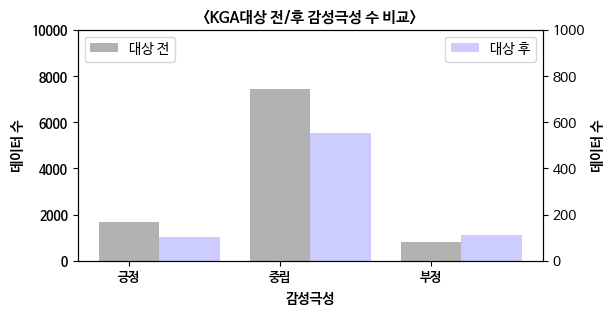

In [15]:
fig, plt1 = plt.subplots()
plt.rcParams["figure.figsize"] = (6, 3)
plot_option02("감성극성", "데이터 수", "<KGA대상 전/후 감성극성 수 비교>")
plt1.bar(x-0.0, before_3opinion, color = 'k', alpha = 0.3, label = "대상 전", width=0.4, align='center')
plt1.legend(loc='upper left'); plt.xticks(x, label); plt.ylim([0, 10000])

plt2 = plt1.twinx()
plt2.bar(x+0.4, after_3opinion, color = 'blue', alpha = 0.2, label = "대상 후", width=0.4, align='center')
plt2.legend(loc='upper right'); plt.ylim([0, 1000]); plt2.set_ylabel('데이터 수', fontweight='bold')
plt.show()

### **KGA대상 전/후 평점극성, 데이터 수 비교**

In [16]:
## 데이터 재정의

# KGA대상 전 데이터의 평점극성 데이터 수
before_positi  = Before_Data[Before_Data['평점극성'] == "긍정"]["평점극성"].count()
before_negati  = Before_Data[Before_Data['평점극성'] == "중립"]["평점극성"].count()
before_neutral = Before_Data[Before_Data['평점극성'] == "부정"]["평점극성"].count()
before_3opinion = [before_positi, before_negati, before_neutral]

# KGA대상 후 데이터의 평점극성 데이터 수
after_positi  = After_Data[After_Data['평점극성'] == "긍정"]["평점극성"].count()
after_negati  = After_Data[After_Data['평점극성'] == "중립"]["평점극성"].count()
after_neutral = After_Data[After_Data['평점극성'] == "부정"]["평점극성"].count()
after_3opinion = [after_positi, after_negati, after_neutral]

label = ["긍정", "중립", "부정"]
x = np.arange(len(label))

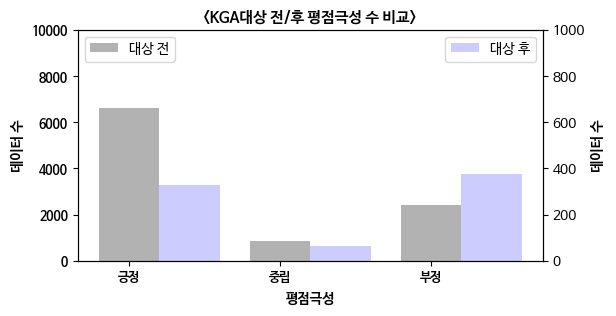

In [17]:
fig, plt1 = plt.subplots()
plt.rcParams["figure.figsize"] = (6, 3)
plot_option02("평점극성", "데이터 수", "<KGA대상 전/후 평점극성 수 비교>")
plt1.bar(x-0.0, before_3opinion, color = 'k', alpha = 0.3, label = "대상 전", width=0.4, align='center')
plt1.legend(loc='upper left'); plt.xticks(x, label); plt.ylim([0, 10000])

plt2 = plt1.twinx()
plt2.bar(x+0.4, after_3opinion, color = 'blue', alpha = 0.2, label = "대상 후", width=0.4, align='center')
plt2.legend(loc='upper right'); plt.ylim([0, 1000]); plt2.set_ylabel('데이터 수', fontweight='bold')
plt.show()

___